# Gaussian Mixture Model
This tutorial demonstrates how to marginalize out discrete latent variables in Pyro through the motivating example of a mixture model. We'll focus on the mechanics of parallel enumeration, keeping the model simple by a training a trivial 1-D Gaussian model on a tiny 5-point dataset.

In [1]:
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
from torch.distributions import constraints
import matplotlib.pyplot as plt
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.3.0')
pyro.enable_validation(True)

## Overview
Pyro’s `TraceEnum_ELBO` can automatically marginalize out variables in both the guide and the model. When enumerating guide variables, Pyro can either enumerate sequentially (which is useful if the variables determine downstream control flow), or enumerate in parallel by allocating a new tensor dimension and using nonstandard evaluation to create a tensor of possible values at the variable’s sample site. These nonstandard values are then replayed in the model. When enumerating variables in the model, the variables must be enumerated in parallel and must not appear in the guide. Mathematically, guide-side enumeration simply reduces variance in a stochastic ELBO by enumerating all values, whereas model-side enumeration avoids an application of Jensen’s inequality by exactly marginalizing out a variable.

Here is our tiny dataset. It has five points.

In [2]:
data = torch.tensor([0., 1., 10., 11., 12])

## Training a MAP estimator
Let’s start by learning model parameters `weights`, `locs`, and `scale` given priors and data. We will learn point estimates of these using an AutoDelta guide (named after its delta distributions). Our model will learn global mixture weights, the location of each mixture component, and a shared scale that is common to both components. During inference, `TraceEnum_ELBO` will marginalize out the assignments of datapoints to clusters.

In [6]:
K = 2 # Fixed number of components.
@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))
        
    with pyro.plate('data', len(data)):
        # Local variables
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)
        
global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']))

To run inference with this `(model, guide)` pair, we use Pyro's `config_enumerate()` handler to enumerate over all assignment in each iteration. Since we've wrapped the batched Categorical assignments in a `pyro.plate` independence context, this enumeration can happen in parallel: we enumerate only 2 possibilities, rather than `2**len(data)=32`. FInally, to use the parallel version of enumeration, we inform Pyro that we are only using a single `plate` via `max_plate_nesting=1`; this lets Pyro know that we're using the rightmost dimension `plate` and that Pyro can use any other dimension for parallelisation.

In [7]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas':[0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)

Before inference we'll initialize to plausible values. Mixture models are very succeptible to local modes. A common approach is choose the best among many random initializations, where the cluster means are initialized from random subsamples of the data. Since we are using an `AutoDelta` guide, we can initialize one parameter for each variable, where the name is prefixed by `auto_` and the constraint is appropriate for each distribution (you can find constraint from the `Distribution.support` attribute)

In [8]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)
    # Assume half of the data variance is due to intra-component noise
    pyro.param('auto_scale', (data.var() / 2).sqrt(), constraint=constraints.positive)
    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)]);
    loss = svi.loss(model, global_guide, data)
    return loss
# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 7, initial_loss = 25.665584564208984


During training, we'll collect both losses and gradient norms to monitor convergence. We can do this using PyTorch's `.register_hook()` method.

In [10]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))
    
losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

Text(0.5, 1.0, 'Convergence of SVI')

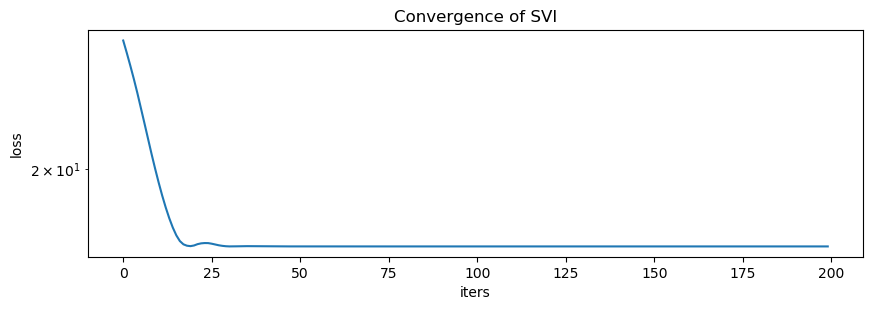

In [11]:
plt.figure(figsize=(10, 3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI')